In [48]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def flat_for(a, f):
    a = a.reshape(-1)
    for i, v in enumerate(a):
        a[i] = f(v)

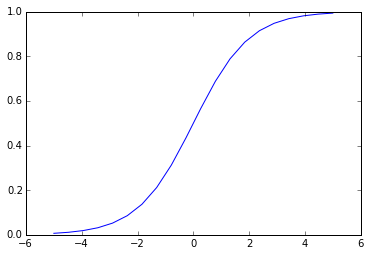

In [46]:
xs = np.linspace(-5, 5, 20)
plt.plot(xs, [sigmoid(x) for x in xs])

In [59]:
class NeuralNetwork:
    """
    basic neural network with training via backpropagation (non-vectorized)
        follows notation from Andrew Ng's Machine Learning Coursera Course (week 5)
    """
    
    def __init__(self, layer_sizes):
        self.layer_sizes = layer_sizes
        self.epsilon = 0.25
        np.random.seed(0)
        # one row is added for bias term
        transitions = [layer_sizes[i:i+2] for i in range(0, len(layer_sizes)-1)]
        self.layer_dim_edges = [(t[1],t[0]+1) for t in transitions]
        self.thetas      = [np.random.rand(t[0], t[1]) * 2 * self.epsilon - self.epsilon for t in self.layer_dim_edges]
        self.lambda_val  = 0.0001
        self.num_layers = len(self.thetas)
        print "layer theta initialization:"
        for theta in self.thetas:
            print theta
            print
            
    def unflatten_thetas(self, flat):
        current = 0
        unflattened = []
        for dims in self.layer_dim_edges:
            count = dims[0] * dims[1]
            unflattened += np.reshape(flat[current:current+count], dims)
            current += count
        return unflattened
    
    def flatten(self, ary):
        return np.hstack([np.asarray(ele.flatten()) for ele in ary])
    
    def train(self, xs, ys):
        m = float(xs.shape[0])
        def cost(new_thetas_flat):
            # compute j value
            j = self.lambda_val / (2.0 * m) * np.sum(np.power(new_thetas_flat, 2))
            for i in range(xs.shape[0]):
                h_theta = self.forward_propagate(xs[i], thetas = self.unflatten_thetas(new_thetas_flat))[-1]
                j += ys[i] * h_theta + (1.0 - ys[i]) * np.log(1.0 - h_theta)
            return j
        def cost_prime(new_thetas_flat):
            # compute new D
            D = self.back_propagate(xs, ys, thetas = self.unflatten_thetas(new_thetas_flat))
            D = flatten(D)
            return D
        return opt.fmin_l_bfgs_b(cost, self.flatten(self.thetas), fprime=cost_prime)
            
    def forward_propagate(self, x, thetas = None):
        thetas = thetas if thetas != None else self.thetas
        state = x
        activations = [self.add_bias_w(x)]
        for theta in thetas[:-1]:
            state = self.layer_step(theta, activations[-1])
            flat_for(state, sigmoid)
            activations.append(self.add_bias_w(state))
        activations.append(self.layer_step(thetas[-1], activations[-1]))
        return activations
    
    def compute_gradient(self, x, y, thetas = None):
        thetas = thetas if thetas != None else self.thetas
        activations = self.forward_propagate(x.T)
        deltas = [None] * (self.num_layers+1)
        grad = [None] * self.num_layers
        deltas[-1] = activations[-1] - y.T
        for l in range(self.num_layers-1, 0, -1):
            deltas[l] = np.multiply(thetas[l].T.dot(deltas[l+1]),
                                    np.multiply(activations[l], 1.0 - activations[l]))
        for l in range(0, self.num_layers):
            # remove the change in bias term activation when propagating to earlier layers
            delta_sel = deltas[l+1] if l == self.num_layers-1 else deltas[l+1][1:,:]
            grad[l] = delta_sel.dot(activations[l].T)
        return grad
    
    def back_propagate(self, xs, ys):
        assert(xs.shape[0] == ys.shape[0])
        m = float(len(xs))
        D = self.compute_gradient(xs[0], ys[0])
        for x, y in zip(xs[1:], ys[1:]):
            xyD = self.compute_gradient(x, y)
            for l in range(0, self.num_layers):
                D[l] += xyD[l]
        for l in range(0, self.num_layers):
            D[l] /= m
        D[l][:,1:] += self.lambda_val * self.thetas[l][:,1:]
        return D
    
    def update(self, D):
        for i in range(0,len(self.thetas)):
            self.thetas[i] -= D[i]
    
    def add_bias_w(self, v):
        return np.vstack([np.matrix([[1]]), v])
    
    # theta(nodes_ldim x input_dim) * x_or_z(input_dim x 1)
    def layer_step(self, theta, x_or_z):
        return theta.dot(x_or_z)

In [60]:
layer_sizes = [2, 2, 1]
nn = NeuralNetwork(layer_sizes)

np.random.seed(0)
#for i in range(0,10000):
xs = np.matrix([[0.0, 0.0], [1.0, 0.0], [1.0, 1.0], [0.0, 1.0]] * 2500) + np.random.randn(10000,2) * 0.05
ys = np.matrix([[0.0], [1.0], [0.0], [1.0]] * 2500)
nn.train(xs,ys)
#D = nn.back_propagate(xs, ys)
#    nn.update(D)

#print "new thetas:"
#for theta in nn.thetas:
#    print theta
#    print

layer theta initialization:
[[ 0.02440675  0.10759468  0.05138169]
 [ 0.02244159 -0.0381726   0.07294706]]

[[-0.03120639  0.1958865   0.23183138]]



ValueError: operands could not be broadcast together with shapes (0,) (2,3) 

In [25]:
tests = [[0.0,1.0],[1.0,0.0],[0.0,0.0],[1.0,1.0]]
print tests

[nn.forward_propagate(np.matrix([t]).T)[-1] for t in tests]

[[0.0, 1.0], [1.0, 0.0], [0.0, 0.0], [1.0, 1.0]]


[matrix([[ 0.99669106]]),
 matrix([[ 1.0056668]]),
 matrix([[-0.01370508]]),
 matrix([[-0.01048806]])]

In [13]:
zip(np.matrix(tests),np.matrix([[1.0,1.0,0.0,0.0]]).T)

[(matrix([[ 0.,  1.]]), matrix([[ 1.]])),
 (matrix([[ 1.,  0.]]), matrix([[ 1.]])),
 (matrix([[ 0.,  0.]]), matrix([[ 0.]])),
 (matrix([[ 1.,  1.]]), matrix([[ 0.]]))]

In [33]:
np.hstack(np.asarray(np.matrix([[1,3],[1,2]]).flatten()))

array([1, 3, 1, 2])